# Genre recognition using ConvNet

inspired by Leland Roberts. https://github.com/lelandroberts97/Musical_Genre_Classification/tree/master/code.
This notebook makes sense of images that are constructed from the MFCC features of each songs and tries to recognize the genre based on the precomputed genre MFCC plots.

However, we will see that this model only reaches an overall accuracy of 0.33, being clearly inferior to perceptron and SVM.

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import pathlib
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import librosa
import librosa.feature
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

/home/cornelius/anaconda3/envs/robocup/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cornelius/anaconda3/envs/robocup/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cornelius/anaconda3/envs/robocup/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cornelius/anaconda3/envs/rob

## 1. Inspect one song
This is to get a feeling for the data and the filters that we want to use

In [2]:
# Extracting the wave, "y", and sampling rate, "sr", of the audio file
y, sr = librosa.load('genres/disco/disco.00000.wav')
y_rec, sr_rec = librosa.load("../../recordings/output.wav")

# Checking the audio wave and sampling rate
y.shape, sr, sr_rec

((664180,), 22050, 22050)

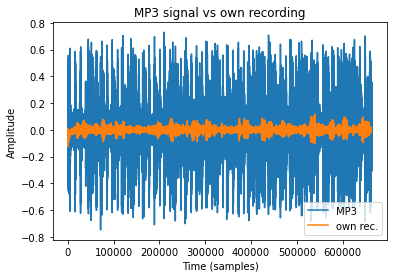

In [3]:
# Plotting the wave
plt.plot(y, label='MP3')
plt.plot(y_rec, label='own rec.')
plt.title('MP3 signal vs own recording')
plt.legend()
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude');

As you can see, the shapes of the two waves differ substantially. The problem is that the one audio is a clean MP3 and te second audio is a phone recording of laptop output.

#### Filter
Hence, we use a filter to make signals be more similar.

In [4]:
def band_filter(file):
    lo, hi = 600,10000
    y, sr = librosa.load(file)
    b, a = butter(N=6, Wn=[2*lo/sr, 2*hi/sr], btype='band')
    x = lfilter(b,a,y)
    return x, sr

def compress_filter(file):
    y, sr = librosa.load(file)
    x = librosa.mu_compress(y, quantize=False)
    return x, sr

(128, 660) (128, 660)


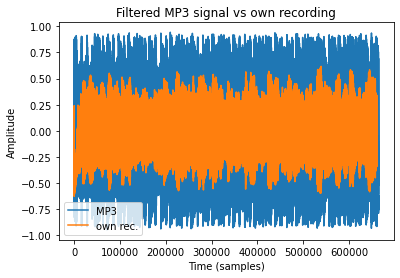

In [18]:
# now filter
filtered_mp3,_ = compress_filter('genres/disco/disco.00000.wav')
filtered_rec,_ = compress_filter("../../recordings/output.wav")

# Plotting the filtered waves
plt.plot(filtered_mp3, label='MP3')
plt.plot(filtered_rec, label='own rec.')
plt.title('Filtered MP3 signal vs own recording')
plt.legend()
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude');

## 2. Read and extract Mel Spectrogram for audiofiles

In this step we get the data and write it to files in order to be faster in the later steps

In [6]:
#GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
GENRES = ['classical', 'jazz', 'metal']

In [21]:
def extract_mfcc():
    all_features = []
    all_labels = []

    # load all songs from the gtzan data set
    for genre in GENRES:
        sound_files = glob.glob('genres/' + genre + '/*.wav')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for file in sound_files:
            # Loading in the audio file
            #y, sr = librosa.core.load(file)
            y, sr = compress_filter(file)
        
            # Computing the MFCC
            mfcc = librosa.feature.mfcc(filtered_mp3)
            mfcc /= np.amax(np.absolute(mfcc))

            # Adjusting the size to be 128 x 660
            mfcc = np.resize(mfcc, (128,660))

            all_features.append(mfcc)
            all_labels.append(genre)

    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))

    # store features and labels
    features = np.array(all_features)
    labels = onehot_labels
    return features, labels

In [22]:
# Using the function to read and extract mel spectrograms from the GTZAN Genre Dataset audio files
#X, y = extract_mel_spectrogram()

Processing 100 songs in classical genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...


## 3. Convolutional Neural Network (CNN)
First we will extract the mfcc scores form the training data, then we will preprocess the data and split it into train and test set.

In [25]:
# Using the function to read and extract mel spectrograms from the GTZAN Genre Dataset audio files
X, y = extract_mfcc()

Processing 100 songs in classical genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...


In [26]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)

To improve the performance of the model, we will scale the data to an interval of 0 and 1.

In [27]:
# Scaling our data to be between 0 and 1
X_train /= X_train.min()
X_test /= X_train.min()

# Reshaping images to be 128 x 660 x 1, where the 1 represents the single color channel
X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)


#### Constructing the CNN
We use `MaxPooling` and two convolution layers. Furthermore, we also make use of dropout.

In [29]:
# Initializing a random seed for replication purposes
np.random.seed(23456)
tf.random.set_random_seed(123) # tf.random.set_seed(16)

# Initiating an empty neural network
cnn_model = Sequential(name='cnn_1')

# Adding convolutional layer
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(128,660,1)))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten())

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25))

# Adding an output layer
cnn_model.add(Dense(len(GENRES), activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=15)

Train on 240 samples, validate on 60 samples
Epoch 1/15
240/240 [==============================] - 9s 35ms/sample - loss: 1.4843 - acc: 0.3042 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/15
240/240 [==============================] - 7s 28ms/sample - loss: 1.1013 - acc: 0.3292 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/15
240/240 [==============================] - 8s 31ms/sample - loss: 1.1009 - acc: 0.3208 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/15
240/240 [==============================] - 7s 28ms/sample - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/15
240/240 [==============================] - 8s 32ms/sample - loss: 1.0987 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 6/15
240/240 [==============================] - 8s 32ms/sample - loss: 1.0987 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 7/15
240/240 [==============================] - 8s 31ms/sample - loss: 1.0987 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 8/15

#### Plot loss

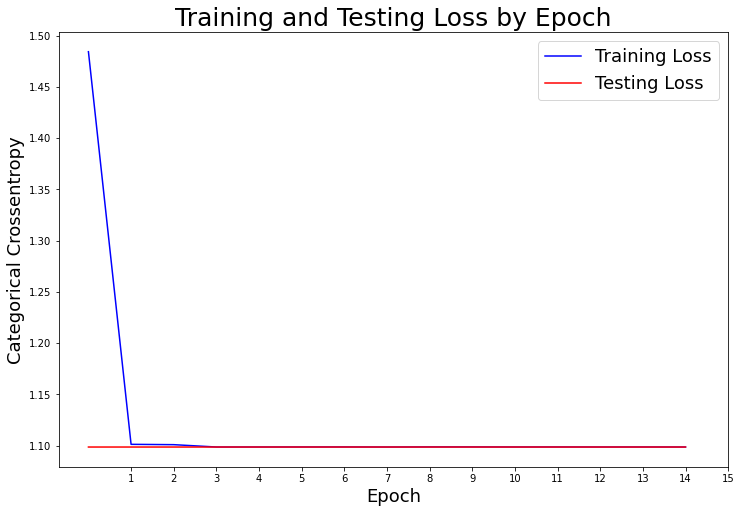

In [30]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,16), range(1,16))

plt.legend(fontsize = 18);

We can see that the loss goes down wuite wuickly, but it generally remains very high. Next we will look at the accuracy.

#### Plot accuracy
In order to understand how well the model performed, we will look at the accuracy next

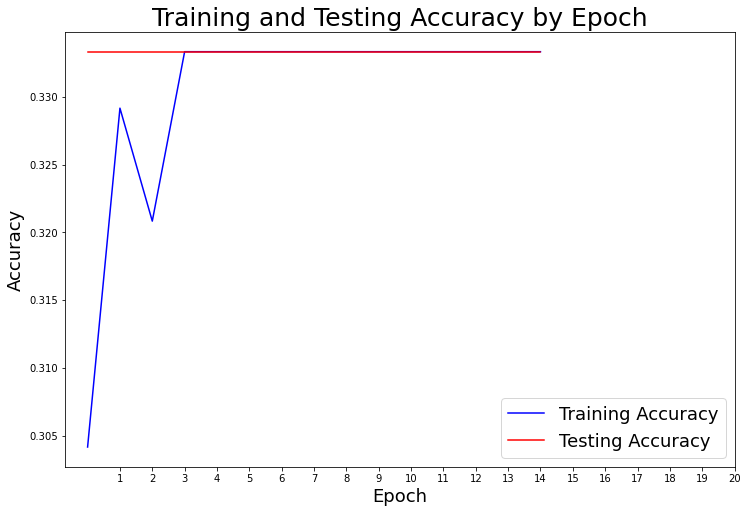

In [35]:
# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['acc']
test_loss = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(1,21), range(1,21))

plt.legend(fontsize = 18);

As we can see: the accuracy is really low, summiting at 0.33. It seems like a convolutional neural network is not ideal, at least with our computing power and data set. Hence we will use the SVM that we describe in the ```genreIdentifier.py``` notebook.